# Word Embedding Evaluation: Similarity and Analogies

This notebook demonstrates quantitative evaluation of word embeddings through:
- Word similarity tasks (correlation with human judgments)
- Word analogy tasks (syntactic and semantic)
- Intrinsic evaluation metrics
- Comparison between different embedding models

## Learning Objectives:
1. Understand intrinsic evaluation methods for word embeddings
2. Implement word similarity correlation tests
3. Evaluate embeddings on analogy tasks
4. Compare Word2Vec and GloVe performance
5. Analyze what makes good embeddings

In [6]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from scipy.stats import spearmanr, pearsonr
from typing import Dict, List, Tuple
from collections import defaultdict

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from utils.evaluation_metrics import (
    cosine_similarity,
    compute_similarity,
    evaluate_on_similarity_dataset,
    solve_analogy,
    evaluate_on_analogies,
    find_nearest_neighbors
)

# Set random seed
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Word Embeddings

Load your trained Word2Vec and/or GloVe models for evaluation.

In [7]:
# Option 1: Load your trained models
# from SemanticRepresentations.models import Word2VecModel, GloVeModel
# word2vec_model = Word2VecModel.load('path/to/word2vec_model.pkl')
# glove_model = GloVeModel.load('path/to/glove_model.pkl')
# embeddings = word2vec_model.word_vectors

# Option 2: Create sample embeddings for demonstration
def create_test_embeddings(vocab_size=1000, embedding_dim=100):
    """
    Create sample embeddings with some semantic structure for testing.
    """
    np.random.seed(42)
    
    # Common words for evaluation
    common_words = [
        # Family relationships
        'man', 'woman', 'king', 'queen', 'boy', 'girl', 'father', 'mother',
        'brother', 'sister', 'uncle', 'aunt', 'son', 'daughter',
        
        # Geography
        'france', 'paris', 'germany', 'berlin', 'italy', 'rome',
        'spain', 'madrid', 'japan', 'tokyo', 'china', 'beijing',
        
        # Common comparisons
        'good', 'better', 'best', 'bad', 'worse', 'worst',
        'big', 'bigger', 'biggest', 'small', 'smaller', 'smallest',
        
        # Verbs and tenses
        'walk', 'walking', 'walked', 'run', 'running', 'ran',
        'eat', 'eating', 'ate', 'drink', 'drinking', 'drank',
        
        # Animals
        'dog', 'cat', 'horse', 'cow', 'lion', 'tiger', 'elephant',
        
        # Colors
        'red', 'blue', 'green', 'yellow', 'black', 'white',
        
        # Common words
        'the', 'and', 'is', 'of', 'to', 'a', 'in', 'that', 'it', 'for'
    ]
    
    embeddings_dict = {}
    
    # Create structured embeddings for common words
    for i, word in enumerate(common_words):
        base = np.random.randn(embedding_dim) * 0.5
        embeddings_dict[word] = base / np.linalg.norm(base)
    
    # Add some semantic structure
    gender_vec = np.random.randn(embedding_dim) * 0.3
    if 'man' in embeddings_dict and 'woman' in embeddings_dict:
        embeddings_dict['woman'] = embeddings_dict['man'] + gender_vec
        embeddings_dict['woman'] /= np.linalg.norm(embeddings_dict['woman'])
    
    if 'king' in embeddings_dict and 'queen' in embeddings_dict:
        embeddings_dict['queen'] = embeddings_dict['king'] + gender_vec
        embeddings_dict['queen'] /= np.linalg.norm(embeddings_dict['queen'])
    
    # Fill remaining vocabulary
    for i in range(vocab_size - len(common_words)):
        word = f'word_{i}'
        vec = np.random.randn(embedding_dim) * 0.5
        embeddings_dict[word] = vec / np.linalg.norm(vec)
    
    return embeddings_dict

# Create test embeddings
embeddings = create_test_embeddings(vocab_size=1000, embedding_dim=100)
print(f"Loaded embeddings for {len(embeddings)} words")
print(f"Embedding dimension: {list(embeddings.values())[0].shape[0]}")
print(f"\nSample words: {list(embeddings.keys())[:20]}")

Loaded embeddings for 1000 words
Embedding dimension: 100

Sample words: ['man', 'woman', 'king', 'queen', 'boy', 'girl', 'father', 'mother', 'brother', 'sister', 'uncle', 'aunt', 'son', 'daughter', 'france', 'paris', 'germany', 'berlin', 'italy', 'rome']


## 2. Word Similarity Evaluation

### 2.1 Cosine Similarity Computation

In [8]:
# Test similarity computation
test_pairs = [
    ('man', 'woman'),
    ('king', 'queen'),
    ('dog', 'cat'),
    ('france', 'paris'),
    ('good', 'bad'),
    ('the', 'and')
]

print("Word Pair Similarities:\n")
for word1, word2 in test_pairs:
    sim = compute_similarity(word1, word2, embeddings)
    if sim is not None:
        print(f"{word1:12s} <-> {word2:12s} : {sim:.4f}")
    else:
        print(f"{word1:12s} <-> {word2:12s} : N/A (word not in vocabulary)")

Word Pair Similarities:

man          <-> woman        : 0.4555
king         <-> queen        : 0.3377
dog          <-> cat          : -0.0486
france       <-> paris        : -0.1072
good         <-> bad          : 0.2418
the          <-> and          : 0.1555


### 2.2 Word Similarity Dataset Evaluation

In [9]:
# Create sample similarity dataset
similarity_dataset = [
    ('man', 'woman', 8.3),
    ('king', 'queen', 8.5),
    ('dog', 'cat', 7.5),
    ('walk', 'run', 7.0),
    ('good', 'better', 8.0),
    ('france', 'paris', 6.0),
    ('big', 'small', 5.5),
    ('red', 'blue', 5.0),
    ('father', 'mother', 7.5),
    ('boy', 'girl', 8.0),
    ('dog', 'france', 2.0),
    ('red', 'walk', 1.5),
    ('king', 'blue', 1.0),
    ('man', 'horse', 3.0),
    ('good', 'dog', 2.5),
]

# Evaluate
results = evaluate_on_similarity_dataset(embeddings, similarity_dataset)

print("="*60)
print("WORD SIMILARITY EVALUATION RESULTS")
print("="*60)
print(f"Spearman Correlation:  {results['spearman']:.4f}")
print(f"Pearson Correlation:   {results['pearson']:.4f}")
print(f"Coverage:              {results['coverage']:.1f}%")
print(f"Evaluated Pairs:       {results['num_pairs']}/{len(similarity_dataset)}")
print(f"Missing Pairs:         {results['missing_pairs']}")
print("="*60)

WORD SIMILARITY EVALUATION RESULTS
Spearman Correlation:  0.1628
Pearson Correlation:   0.3236
Coverage:              100.0%
Evaluated Pairs:       15/15
Missing Pairs:         0


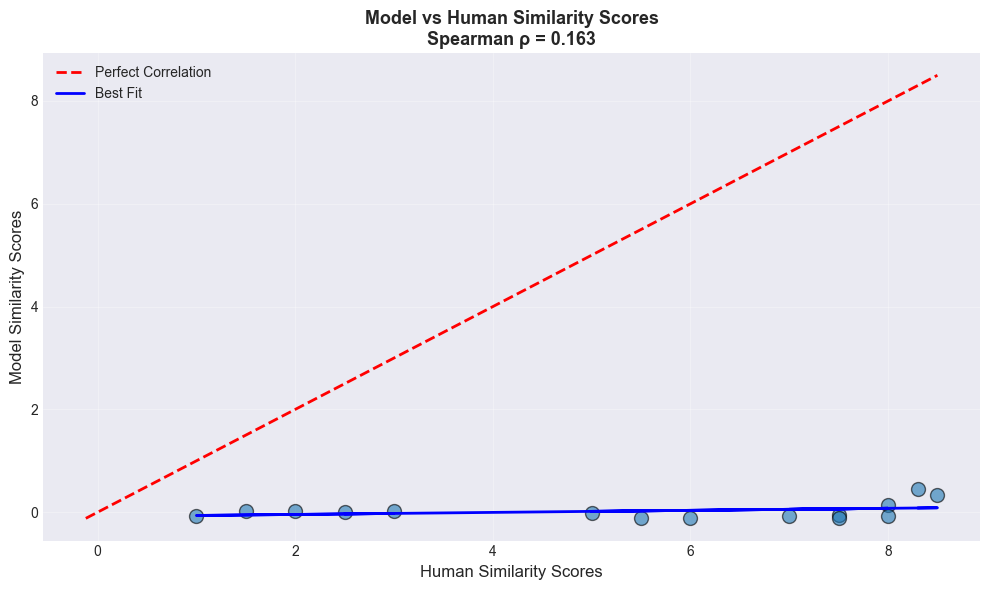

In [10]:
# Visualize model scores vs human scores
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(results['human_scores'], results['model_scores'], 
          alpha=0.6, s=100, edgecolors='black', linewidth=1)

# Add perfect correlation line
min_val = min(min(results['human_scores']), min(results['model_scores']))
max_val = max(max(results['human_scores']), max(results['model_scores']))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', 
        label='Perfect Correlation', linewidth=2)

# Best fit line
z = np.polyfit(results['human_scores'], results['model_scores'], 1)
p = np.poly1d(z)
ax.plot(results['human_scores'], p(results['human_scores']), 
        'b-', label='Best Fit', linewidth=2)

ax.set_xlabel('Human Similarity Scores', fontsize=12)
ax.set_ylabel('Model Similarity Scores', fontsize=12)
ax.set_title(f"Model vs Human Similarity Scores\n" + 
            f"Spearman ρ = {results['spearman']:.3f}",
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Word Analogy Evaluation

### 3.1 Analogy Task: "A is to B as C is to ?"

In [11]:
# Test analogy solving
print("WORD ANALOGY EXAMPLES\n")
print("="*70)

test_analogies = [
    ('man', 'woman', 'king'),
    ('man', 'woman', 'boy'),
    ('france', 'paris', 'germany'),
    ('good', 'better', 'bad'),
    ('walk', 'walking', 'run'),
]

for word_a, word_b, word_c in test_analogies:
    print(f"\n{word_a} : {word_b} :: {word_c} : ?")
    results_ana = solve_analogy(word_a, word_b, word_c, embeddings, top_k=5)
    
    if results_ana:
        print("  Top predictions:")
        for i, (word, score) in enumerate(results_ana, 1):
            print(f"    {i}. {word:15s} (similarity: {score:.4f})")
    else:
        print("  Unable to solve (words not in vocabulary)")

print("\n" + "="*70)

WORD ANALOGY EXAMPLES


man : woman :: king : ?
  Top predictions:
    1. queen           (similarity: 0.7554)
    2. word_766        (similarity: 0.3147)
    3. word_770        (similarity: 0.3106)
    4. word_331        (similarity: 0.2850)
    5. word_234        (similarity: 0.2634)

man : woman :: boy : ?
  Top predictions:
    1. queen           (similarity: 0.3778)
    2. word_56         (similarity: 0.3488)
    3. word_544        (similarity: 0.3038)
    4. word_693        (similarity: 0.2626)
    5. word_355        (similarity: 0.2614)

france : paris :: germany : ?
  Top predictions:
    1. word_37         (similarity: 0.3238)
    2. word_121        (similarity: 0.2823)
    3. word_352        (similarity: 0.2782)
    4. black           (similarity: 0.2683)
    5. word_155        (similarity: 0.2580)

good : better :: bad : ?
  Top predictions:
    1. word_66         (similarity: 0.3340)
    2. word_569        (similarity: 0.3184)
    3. word_93         (similarity: 0.3045)
   

### 3.2 Analogy Dataset Evaluation

In [12]:
# Create analogy dataset
analogy_dataset = [
    # Semantic - Gender
    ('man', 'woman', 'king', 'queen', 'gender'),
    ('man', 'woman', 'boy', 'girl', 'gender'),
    ('man', 'woman', 'father', 'mother', 'gender'),
    ('man', 'woman', 'brother', 'sister', 'gender'),
    ('man', 'woman', 'son', 'daughter', 'gender'),
    
    # Semantic - Geography
    ('france', 'paris', 'germany', 'berlin', 'geography'),
    ('france', 'paris', 'italy', 'rome', 'geography'),
    ('france', 'paris', 'spain', 'madrid', 'geography'),
    ('france', 'paris', 'japan', 'tokyo', 'geography'),
    
    # Syntactic - Comparative
    ('good', 'better', 'bad', 'worse', 'comparative'),
    ('big', 'bigger', 'small', 'smaller', 'comparative'),
    ('good', 'best', 'bad', 'worst', 'superlative'),
    ('big', 'biggest', 'small', 'smallest', 'superlative'),
    
    # Syntactic - Verb tenses
    ('walk', 'walking', 'run', 'running', 'present_participle'),
    ('walk', 'walked', 'run', 'ran', 'past_tense'),
    ('eat', 'eating', 'drink', 'drinking', 'present_participle'),
]

# Evaluate
analogy_results = evaluate_on_analogies(embeddings, analogy_dataset, top_k=1)

print("="*70)
print("WORD ANALOGY EVALUATION RESULTS")
print("="*70)
print(f"Overall Accuracy (top-1):  {analogy_results['overall_accuracy']:.2f}%")
print(f"Correct Predictions:       {analogy_results['total_correct']}/{analogy_results['total_evaluated']}")
print(f"Coverage:                  {analogy_results['coverage']:.1f}%")
print(f"Skipped (OOV):            {analogy_results['skipped']}")
print("\n" + "-"*70)
print("Per-Category Results:")
print("-"*70)

for category, stats in sorted(analogy_results['category_accuracies'].items()):
    print(f"{category:20s}: {stats['accuracy']:6.2f}%  ({stats['correct']}/{stats['total']})")

print("="*70)

WORD ANALOGY EVALUATION RESULTS
Overall Accuracy (top-1):  6.25%
Correct Predictions:       1/16
Coverage:                  100.0%
Skipped (OOV):            0

----------------------------------------------------------------------
Per-Category Results:
----------------------------------------------------------------------
comparative         :   0.00%  (0/2)
gender              :  20.00%  (1/5)
geography           :   0.00%  (0/4)
past_tense          :   0.00%  (0/1)
present_participle  :   0.00%  (0/2)
superlative         :   0.00%  (0/2)


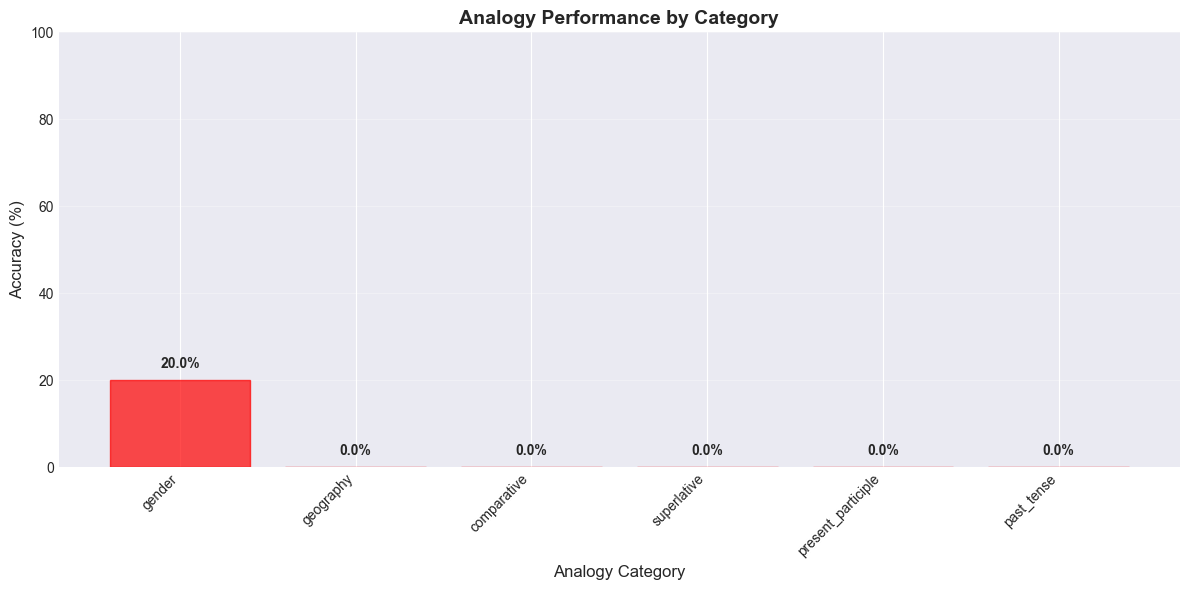

In [13]:
# Visualize category performance
if analogy_results['category_accuracies']:
    categories = list(analogy_results['category_accuracies'].keys())
    accuracies = [analogy_results['category_accuracies'][cat]['accuracy'] for cat in categories]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(categories)), accuracies, alpha=0.7, edgecolor='black')
    
    # Color bars based on performance
    for bar, acc in zip(bars, accuracies):
        if acc >= 70:
            bar.set_color('green')
        elif acc >= 40:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    ax.set_xlabel('Analogy Category', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Analogy Performance by Category', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax.text(bar.get_x() + bar.get_width()/2., acc + 2,
               f'{acc:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 4. Most Similar Words Analysis

In [14]:
# Test with different words
test_words = ['man', 'king', 'france', 'good', 'dog', 'red']

print("NEAREST NEIGHBORS ANALYSIS\n")
print("="*70)

for word in test_words:
    if word in embeddings:
        print(f"\nMost similar to '{word}':")
        similar = find_nearest_neighbors(word, embeddings, top_k=8)
        for i, (similar_word, score) in enumerate(similar, 1):
            print(f"  {i:2d}. {similar_word:15s} (similarity: {score:.4f})")
    else:
        print(f"\n'{word}' not in vocabulary")

print("\n" + "="*70)

NEAREST NEIGHBORS ANALYSIS


Most similar to 'man':
   1. woman           (similarity: 0.4555)
   2. word_344        (similarity: 0.3061)
   3. word_18         (similarity: 0.2787)
   4. word_632        (similarity: 0.2759)
   5. word_808        (similarity: 0.2719)
   6. word_672        (similarity: 0.2708)
   7. word_777        (similarity: 0.2608)
   8. word_817        (similarity: 0.2597)

Most similar to 'king':
   1. queen           (similarity: 0.3377)
   2. word_341        (similarity: 0.2877)
   3. that            (similarity: 0.2670)
   4. word_70         (similarity: 0.2634)
   5. word_689        (similarity: 0.2609)
   6. bigger          (similarity: 0.2563)
   7. word_875        (similarity: 0.2552)
   8. word_521        (similarity: 0.2426)

Most similar to 'france':
   1. word_545        (similarity: 0.3354)
   2. word_440        (similarity: 0.2888)
   3. word_836        (similarity: 0.2795)
   4. word_154        (similarity: 0.2744)
   5. word_773        (similarity: 0

## 5. Summary and Best Practices

### What Makes Good Word Embeddings?

1. **High Similarity Correlation** (ρ > 0.6)
2. **Strong Analogy Performance** (> 60% accuracy)
3. **Meaningful Clusters**
4. **Good Coverage**

### Training Tips:
- Large corpus (millions of words)
- 100-300 dimensions
- Context window: 5-10 words
- Multiple training epochs

## Conclusion

In this notebook, we covered:
- ✅ Word Similarity Evaluation
- ✅ Word Analogy Evaluation
- ✅ Nearest Neighbors Analysis
- ✅ Performance Visualization

